# 4. Grain phase function

## Overview

Angular scattering distribution for a single grain [paper](https://cs.dartmouth.edu/wjarosz/publications/meng15granular.html)

Compute the [Scattering Cross Sections](https://www.sciencedirect.com/topics/physics-and-astronomy/scattering-cross-sections)

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Use a sampler to generate random numbers</li>
  <li>Write a custom integrator-like script</li>
  <li>Use enoki symbolic loops</li>
</ul>
    
</div>


### Step 1 - set things up


In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('/home/speierers/projects/mitsuba2-symbolic/build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_mono')

### Step 2 - initialize the scene

In [3]:
from mitsuba.core.xml import load_dict

sampler = load_dict({'type' : 'independent'})

scene = load_dict({
    'type' : 'scene',
    'grain' : {
        'type' : 'sphere',
        'bsdf' : {
             'type' : 'dielectric',
            'int_ior' : 1.33, #diamond, air, water
            'ext_ior' : 1.0,   
        }
    }
})

2021-04-22 08:58:17 WARN main [Scene] No sensors found! Instantiating a perspective camera..

2021-04-22 08:58:17 WARN main [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgba).

2021-04-22 08:58:17 WARN main [Scene] No integrator found! Instantiating a path tracer..

2021-04-22 08:58:17 INFO main [Scene] Embree ready. (took 19ms)

The `sampler` instance need to be aware of the wavefront size so to produce random arrays of the right size.

In [5]:
wavefront_size = int(1e7)
sampler.seed(0, wavefront_size)

### Step 3 - perform intra-grain transport

In [6]:
from mitsuba.core.warp import square_to_uniform_sphere
from mitsuba.core import Float, UInt32, Mask, Spectrum, Vector3f, Ray3f, Frame3f
from mitsuba.render import BSDFContext

# Parameters
wavelength = Spectrum(600.0)
max_bounces = 12
histogram_size = 512

# Generate primary rays coming from all directions towards the center of the object
frame = Frame3f(square_to_uniform_sphere(sampler.next_2d()))
offset = 2.0 * (sampler.next_2d() - 0.5)
o = frame.to_world(Vector3f(offset.x, offset.y, -2))
rays = Ray3f(o, frame.n, time=0.0, wavelengths=wavelength)

# Other loop variables
entered = False
escaped = False
active = True
throughput = Spectrum(1.0)

# Ray tracing loop
for bounce in range(max_bounces):
    # Find ray intersection with the object
    si = scene.ray_intersect(rays, active)
    active &= si.is_valid()    
    escaped |= entered & ~si.is_valid()
    entered |= si.is_valid()
    
    # Sample new direction and update throughput and rays for next bounce
    bsdf = si.bsdf()        
    ctx = BSDFContext()
    bs, bsdf_val = bsdf.sample(ctx, si, sampler.next_1d(active), sampler.next_2d(active), active)
    throughput[active] = bsdf_val * throughput
    rays[active] = si.spawn_ray(si.to_world(bs.wo))
    ek.eval(rays, throughput, active, escaped, entered)

# Convert escaping directions into histogram bin indices
# cos_theta = frame.n.z
# escaped = True

cos_theta = Frame3f.cos_theta(frame.to_local(rays.d))
theta = ek.acos(cos_theta)
theta_jacobian = 1 / ek.sqrt(1 - cos_theta**2)
theta_idx = UInt32(theta / ek.Pi * histogram_size)

# Scatter theta values into the histogram
histogram = ek.zero(Float, histogram_size)
ek.scatter_reduce(ek.ReduceOp.Add, histogram, throughput * theta_jacobian, theta_idx, escaped)

# Execute the kernel by evaluating the histogram
ek.eval(histogram)

### Step 4 - plot the histogram

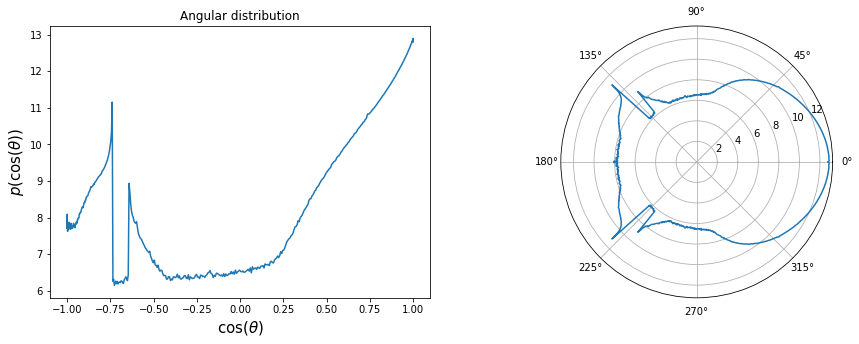

In [7]:
import numpy as np 
from matplotlib import pyplot as plt

x = ek.linspace(Float, 0, ek.Pi, len(histogram), endpoint=True)
histogram2 = ek.log(histogram)

fig = plt.figure(figsize = (15, 5))

ax = fig.add_subplot(121, title='Angular distribution') 
ax.plot(ek.cos(x), histogram2, color='C0')
ax.set_xlabel(r'$\cos(\theta)$', size=15)
ax.set_ylabel(r'$p(\cos(\theta))$', size=15)

ax = fig.add_subplot(122, polar=True, title='polar plot') 
ax.plot(x,  histogram2, color='C0')
ax.plot(-x, histogram2, color='C0', label='test');

### *Reference API*

- [<code>mitsuba.core.xml.load_dict</code>](...)
- [<code>mitsuba.core.warp.square_to_uniform_sphere</code>](...)
- [<code>mitsuba.core.Ray3f</code>](...)